### **Imports**

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import *
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)


C:\Users\HEMA\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### **Mount & set directory**


In [15]:
home_dir = '..\\'
baum_dir = home_dir + 'BAUM\\'

data = pd.read_csv(baum_dir + 'training_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})

data = shuffle(data)
data_valid = shuffle(data_valid)

print("Original data", len(data),  len(data_valid))
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True)
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

data = shuffle(data)
data_valid = shuffle(data_valid)
#ax3 = data['code'].plot.hist(bins=12)

Original data 62884 7508
Less data 22777 4241


In [16]:
#all(train_df_flow['flow'].apply(lambda x: isinstance(x, str)))

### **Image generators**

In [17]:
train_df, valid_df = data , data_valid

batch_size_ = 1024

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()

        frame = X1i[0][0]

        #cv2.imwrite( str(X1i[1][0]) +".png",frame )
        #cv2.imwrite("f.png", X2i[0][0])
        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)


print ("generators initiaized")


Found 22777 validated image filenames belonging to 6 classes.
Found 4241 validated image filenames belonging to 6 classes.
Found 22777 validated image filenames belonging to 6 classes.
Found 4241 validated image filenames belonging to 6 classes.
generators initiaized


In [18]:
# Test generator 
#import numpy as np
#print(train_df['code'][0:10])
#x = next(train_generator)
#np.argmax(x[1][0:10], axis = 1)

from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=(48,48,3),
            classes=6)

vgg.summary()

vgg.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Add checkpoint for model saver
model_dir = baum_dir + 'models\\'
filepath  = model_dir + 'Model_vgg_01.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

callbacks_list = [checkpoint]
 
steps_per_epoch_train = int(len(train_df) / batch_size_)
steps_per_epoch_valid = int(len(valid_df) / batch_size_)
print(steps_per_epoch_train, steps_per_epoch_valid)    

print(len(train_df), len(valid_df))    
    
# Train Model
vgg.fit_generator(train_generator_spatial,
                  steps_per_epoch = steps_per_epoch_train, # 200 # was 1000
                  epochs = 50,
                  validation_data  = validation_generator_spatial,
                  validation_steps = steps_per_epoch_valid, # 80 # was 400
                  callbacks = callbacks_list)

In [19]:
# Original
'''
input_spatial = Input(shape=(48,48,3))
x = layers.Conv2D(64, (5, 5), activation='relu')(input_spatial)
x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
Out_spatial = layers.Flatten()(x)
'''

#04
'''
input_spatial = Input(shape=(48,48,3))
x = layers.Conv2D(64, (5, 5), activation='relu')(input_spatial)
x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
Out_spatial = layers.Flatten()(x)
'''

# 05
'''
input_spatial = Input(shape=(48,48,3))
x = layers.Conv2D(32, (5, 5), activation='relu')(input_spatial)
x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
Out_spatial = layers.Flatten()(x)
'''

"\ninput_spatial = Input(shape=(48,48,3))\nx = layers.Conv2D(64, (5, 5), activation='relu')(input_spatial)\nx = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)\nx = layers.Conv2D(64, (3, 3), activation='relu')(x)\nx = layers.Conv2D(64, (3, 3), activation='relu')(x)\nx = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)\nx = layers.Conv2D(128, (3, 3), activation='relu')(x)\nx = layers.Conv2D(256, (3, 3), activation='relu')(x)\nx = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)\nOut_spatial = layers.Flatten()(x)\n"

### **Model & setting**

In [26]:
def create_model():
    input_spatial = Input(shape=(48,48,3))
    x = layers.Conv2D(32, (5, 5), activation='relu')(input_spatial)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    Out_spatial = layers.Flatten()(x)

    input_flow = Input(shape=(48,48,3))
    x = layers.Conv2D(32, (5, 5), activation='relu')(input_flow)
    x = layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x) #TODO activation 

    x = layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)  
    Out_flow = layers.Flatten()(x)

    merged1 = concatenate([Out_spatial, Out_flow])

    x = layers.Dense(1024, activation='relu')(merged1)
    x = layers.Dropout(0.4)(x)
    '''
    x = layers.Dense(1024, activation='relu',
                kernel_regularizer=l2(0.1))(x)  
    '''
    x = layers.Dense(1024, activation='relu')(x)
    #x = layers.Dropout(0.4)(x)


    Out = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
    return model
  
model = create_model()

model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

### **Train**

In [27]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 44, 44, 32)   2432        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 44, 44, 32)   2432        input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Add checkpoint for model saver
model_dir = baum_dir + 'models\\'
filepath  = model_dir + 'Model_fusion_06.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

callbacks_list = [checkpoint]
 
steps_per_epoch_train = int(len(train_df) / batch_size_)
steps_per_epoch_valid = int(len(valid_df) / batch_size_)
print(steps_per_epoch_train, steps_per_epoch_valid)    

print(len(train_df), len(valid_df))    
    
# Train Model
hist = model.fit_generator(train_generator,
                    steps_per_epoch = steps_per_epoch_train, # 200 # was 1000
                    epochs = 50,
                    validation_data  = validation_generator,
                    validation_steps = steps_per_epoch_valid, # 80 # was 400
                    callbacks = callbacks_list)

22 4
22777 4241
Epoch 1/50
21/22 [===========================>..] - ETA: 6s - loss: 1.7875 - acc: 0.1755 
Epoch 00001: val_acc improved from -inf to 0.15729, saving model to ..\BAUM\models\Model_fusion_06.h5
22/22 [==============================] - 156s 7s/step - loss: 1.7873 - acc: 0.1767 - val_loss: 1.7679 - val_acc: 0.1573
Epoch 2/50
21/22 [===========================>..] - ETA: 5s - loss: 1.7802 - acc: 0.1965 
Epoch 00002: val_acc improved from 0.15729 to 0.16382, saving model to ..\BAUM\models\Model_fusion_06.h5
22/22 [==============================] - 143s 7s/step - loss: 1.7795 - acc: 0.1980 - val_loss: 1.7654 - val_acc: 0.1638
Epoch 3/50
21/22 [===========================>..] - ETA: 5s - loss: 1.7340 - acc: 0.2412 
Epoch 00003: val_acc did not improve from 0.16382
22/22 [==============================] - 145s 7s/step - loss: 1.7333 - acc: 0.2409 - val_loss: 1.7930 - val_acc: 0.1352
Epoch 4/50
21/22 [===========================>..] - ETA: 5s - loss: 1.6867 - acc: 0.2630 
Epoch 0

21/22 [===========================>..] - ETA: 6s - loss: 0.5580 - acc: 0.7850 
Epoch 00030: val_acc did not improve from 0.40441
22/22 [==============================] - 147s 7s/step - loss: 0.5578 - acc: 0.7851 - val_loss: 2.1375 - val_acc: 0.3833
Epoch 31/50
21/22 [===========================>..] - ETA: 6s - loss: 0.5630 - acc: 0.7882 
Epoch 00031: val_acc did not improve from 0.40441
22/22 [==============================] - 156s 7s/step - loss: 0.5598 - acc: 0.7894 - val_loss: 2.4595 - val_acc: 0.3643
Epoch 32/50
21/22 [===========================>..] - ETA: 6s - loss: 0.5114 - acc: 0.8037 
Epoch 00032: val_acc did not improve from 0.40441
22/22 [==============================] - 155s 7s/step - loss: 0.5102 - acc: 0.8049 - val_loss: 2.2948 - val_acc: 0.3715
Epoch 33/50
21/22 [===========================>..] - ETA: 6s - loss: 0.4871 - acc: 0.8140 
Epoch 00033: val_acc did not improve from 0.40441
22/22 [==============================] - 160s 7s/step - loss: 0.4896 - acc: 0.8126 - val

### **End**

### **Data Analysis and Visualization**

In [23]:
sample = data.sample()
print(type(sample))
spatial = sample['spatial'] 
print(type(spatial))
flow = sample['flow'] 
emotion = sample['emotion']
emotion.values[0]#[0]#.get_values()[0]

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


'Disgust'

Unique classes are:  ['5', '2', '6', '3', '4', '1']
['Sadness', 'Disgust', 'Disgust', 'Disgust', 'Happiness']
['fear', 'Fear', 'Sadness', 'Sadness', 'Anger']


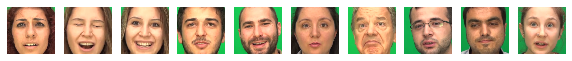

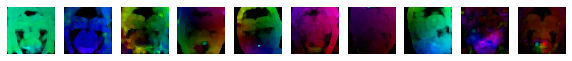

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
data_unique = data['code'].unique().tolist()
print("Unique classes are: ",data_unique)

images = []
images_flow = []
emotions = []
codes = []
i = 0
while i < 10:
    sample = data.sample()
    spatial = sample['spatial'] 
    flow = sample['flow'] 
    emotion = sample['emotion']
    code = sample['code']
    spatial = spatial.values[0]
    flow = flow.values[0]
    emotion = emotion.values[0]
    code = code.values[0]
    img_path = baum_dir + spatial
    img_path_flow = baum_dir +flow
    if (os.path.isfile(img_path)):
        images.append(mpimg.imread(img_path))
        images_flow.append(mpimg.imread(img_path_flow))
        emotions.append(emotion)
        codes.append(code)
        i+=1

plt.figure(figsize=(10,15))
columns = 10

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')

print(emotions[:5])
print(emotions[5:])

plt.figure(figsize=(10,25))
plt.axis('off')
columns = 10

for i, image in enumerate(images_flow):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')


Original data 62884 7508
Less data 22777 4241
22777
4241


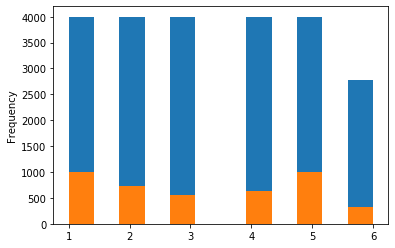

In [25]:
from sklearn.utils import shuffle

home_dir = '..\\'

baum_dir = home_dir + 'BAUM\\'
data = pd.read_csv(baum_dir + 'training_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': int})
data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': int})

data = shuffle(data)
data_valid = shuffle(data_valid)

print("Original data", len(data),  len(data_valid))
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True)
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

ax3 = data['code'].plot.hist(bins=12)
ax3 = data_valid['code'].plot.hist(bins=12)

print(len(data))
print(len(data_valid))



In [13]:
from tensorflow.keras.models import *
filepath  = model_dir + 'lastModel.h5'
save_model(model, filepath)